# Exploratory Data Analysis of Bicycle Accidents In Great Britain (1979 - 2018)

Bicycles for rent are now a popular means of transport in London especially when there are train cancellations or strikes.
There are several providers of this service with Lime and Forest as the most popular e-bike options.
Santander also offers pedal bicycles across the city.

-----------------------------------------------------------------------------------------
Cycling combines exercise and convenient city transport. It improves the cardiovascular and peripheral muscle tone[Reference]
However, this healthy and active transportation has its downsides.
This is therefore an attempt to highlight and understand the public health impact of cycling in London using data from
https://www.kaggle.com/datasets/johnharshith/bicycle-accidents-in-great-britain-1979-to-2018/data

-----------------------------------------------------------------------------------------
This data analysis involved the following steps:
- Load libraries and datasets
- Summarise and clean datasets
- Univariate and Bivariate data analysis
- Data analysis of combined tables

--------------------------------------------------------------------------------------------
Findings
- The most common accident severity category was Slight(n=681578, 82%) whiles Fatal(n=6730, 1%) was the least common.
- This distribution of severity was also observed when severity was compared to gender and age group.
- A majority of accidents involved Males(n= 660031, 79%). Females(n=167721) were involved in 20% of accidents.
- By age group, 11 to 15 (n= 169945, 21%), 26 to 35 (n=145081, 18%) and 16 to 20(n=122604, 15%) were the most frequently involved in accidents.
- 56 to 65(n=41913, 5%) and 66 to 75(n=15663, 2%) were the least frequently involved in bicycle accidents.
- The most males were in the 11-15(21.83) age group and the 26-35(19.50) age group was the most females.

- Accidents happened the most frequently on dry(n=633936, 76.58%) and wet(n=184279, 22.26%) road conditions.
- Accidents occured overwhelmingly on days with clear(n=683162, 82.5%) weather.
- Accidents were also popular on week days than weekends.
- Wednesday(16.52%), Tuesday(16.49%), Thursday(16.46%), Friday(15.95), Monday(15.19%), Saturday(10.59%), Sunday(8.80%).
- Single carriageways(79.33%) were the road type where accidents occured the most.
- 30647(3.70%) accidents occured on roads where the road type was not know.
- Accidents occured the most during  day light (n=660657, 79.80%)
- Number of vehicles(Statistic: 0.4672, p-value: 0.0000), Number of casualties(Statistic: 0.5314, p-value: 0.0000)
  and speed limit (Statistic: 0.4839,  p-value: 0.0000) were statistically(Kolmogorov-Smirnov Test) and
  visually(q-q plot, box-plot) determined to have a non-normal distribution

#### Load libraries and datasets

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline 

In [2]:
# import accidents dataset.
df_Ac = pd.read_csv('E:\Site\Data Analysis\Datasets\Bicycle Accidents UK\Accidents.csv')
df_Ac.head()

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
0,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
1,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
2,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
3,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
4,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit


In [3]:
# import bikers dataset
df_Bk = pd.read_csv('E:\Site\Data Analysis\Datasets\Bicycle Accidents UK\Bikers.csv')
df_Bk.head()

,Accident_Index,Gender,Severity,Age_Grp
0,197901A1SEE71,Male,Serious,36 to 45
1,197901A2JDW40,Male,Slight,46 to 55
2,197901A4IJV90,Male,Slight,46 to 55
3,197901A4NIE33,Male,Slight,36 to 45
4,197901A4SKO47,Male,Slight,46 to 55


#### Get summary of accident dataset

In [4]:
# get shape of accidents dataset
df_Ac.shape

(827861, 11)

In [5]:
# get summary of accidents dataset
df_Ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827861 entries, 0 to 827860
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Accident_Index        827861 non-null  object 
 1   Number_of_Vehicles    827861 non-null  int64  
 2   Number_of_Casualties  827861 non-null  int64  
 3   Date                  827861 non-null  object 
 4   Time                  827861 non-null  object 
 5   Speed_limit           827861 non-null  float64
 6   Road_conditions       827861 non-null  object 
 7   Weather_conditions    827861 non-null  object 
 8   Day                   827861 non-null  object 
 9   Road_type             827861 non-null  object 
 10  Light_conditions      827861 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 69.5+ MB


In [6]:
# get summary of accidents dataset
df_Ac.describe()

,Number_of_Vehicles,Number_of_Casualties,Speed_limit
count,827861.000000,827861.000000,827861.000000
mean,1.986178,1.047212,33.340934
std,0.311600,0.253509,9.278129
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,30.000000
50%,2.000000,1.000000,30.000000
75%,2.000000,1.000000,30.000000
max,13.000000,60.000000,660.000000


#### Data Cleaning for Accidents Dataset

In [7]:
# check the number of duplicates
df_Ac.duplicated().sum()

np.int64(0)

In [8]:
# check the number of null values
df_Ac.isnull().sum()

Accident_Index          0
Number_of_Vehicles      0
Number_of_Casualties    0
Date                    0
Time                    0
Speed_limit             0
Road_conditions         0
Weather_conditions      0
Day                     0
Road_type               0
Light_conditions        0
dtype: int64

In [9]:
# backup original dataset before cleaning
df_Ac_clean = df_Ac
df_Ac_clean.head()

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
0,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
1,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
2,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
3,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
4,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit


In [10]:
# set index of dataframe
df_Ac_clean = df_Ac_clean.set_index('Accident_Index')
df_Ac_clean

,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
Accident_Index,,,,,,,,,,
197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit
...,...,...,...,...,...,...,...,...,...,...
2018983118818,2,1,2018-02-07,14:55,30.0,Dry,Clear,Monday,Single carriageway,Daylight
2018983119218,2,1,2018-07-24,07:45,30.0,Dry,Clear,Tuesday,Single carriageway,Daylight
2018983120618,2,1,2018-10-08,13:25,20.0,Dry,Clear,Friday,Single carriageway,Daylight


In [ ]:
# Change the type of Date from object to datetime
df_Ac_clean_Date = pd.to_datetime(df_Ac_clean["Date"], format="%Y-%m-%d", errors="raise")
df_Ac_clean['Date'] = df_Ac_clean_Date

# Create combined DateTime column
# df_Ac_clean["AccidentDateTime"] = pd.to_datetime(
#     df_Ac_clean["Date"].astype(str) + " " + df_Ac_clean["Time"].astype(str),
#     format="%Y-%m-%d %H:%M",
#     errors="raise"
# )

In [11]:
# Find inconsistent values in Road conditions column
df_Ac_clean['Road_conditions'].value_counts()

Road_conditions
Dry             633936
Wet             184279
Frost             6020
Snow              1710
Missing Data      1648
Flood              268
Name: count, dtype: int64

In [12]:
# Find inconsistent values in Weather conditions column
df_Ac_clean['Weather_conditions'].value_counts()

Weather_conditions
Clear              683162
Rain                82007
Unknown             24081
Clear and windy     11891
Other               11820
Rain and windy       8808
Fog                  3369
Snow                 2086
Snow and windy        483
Missing data          154
Name: count, dtype: int64

In [13]:
# Change 'Missing data' entries to 'Unknown'
df_Ac_clean['Weather_conditions'] = df_Ac_clean['Weather_conditions'].replace('Missing data', 'Unknown')

In [14]:
# Find inconsistent values in Day column
df_Ac_clean['Day'].value_counts()

Day
Wednesday    136756
Tuesday      136534
Thursday     136263
Friday       132066
Monday       125749
Saturday      87652
Sunday        72841
Name: count, dtype: int64

In [15]:
# Find inconsistent values in Road type column
df_Ac_clean['Road_type'].value_counts()

Road_type
Single carriageway    656703
Roundabout             75066
Dual carriageway       59037
Unknown                30647
One way sreet           5562
Slip road                846
Name: count, dtype: int64

In [16]:
# Find inconsistent values in light conditions column
df_Ac_clean['Light_conditions'].value_counts()

Light_conditions
Daylight               660657
Darkness lights lit    142039
Darkness no lights      25165
Name: count, dtype: int64

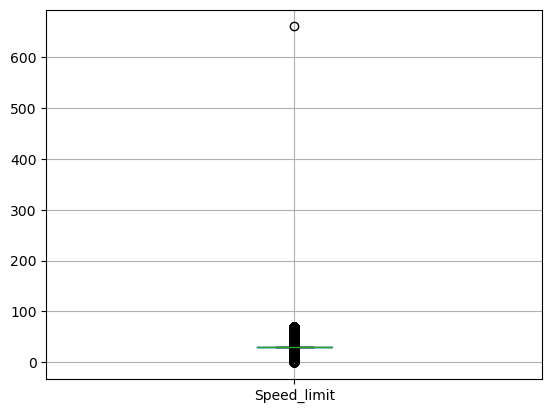

In [17]:
# Boxplot of Speed limit column
df_Ac_clean.boxplot(column=['Speed_limit'])
plt.show()

In [18]:
# Handle outliers in speed limit column
# UK speed limits are between 20mph and 70mph. 
# The value of 660 can be treated as a typographical error and replaced with 66mph, 60mph or the mean.

df_Ac_clean[df_Ac_clean['Speed_limit'] > 600]
df_Ac_clean.at['199032C064990','Speed_limit'] = 66
df_Ac_clean.at['199032C064990','Speed_limit']

np.float64(66.0)

In [163]:
# Check validity of number of casualties and number of vehicles

df_Ac_clean[df_Ac_clean['Number_of_Casualties'] == 0]
df_Ac_clean[df_Ac_clean['Number_of_Vehicles'] == 0]

,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
Accident_Index,,,,,,,,,,


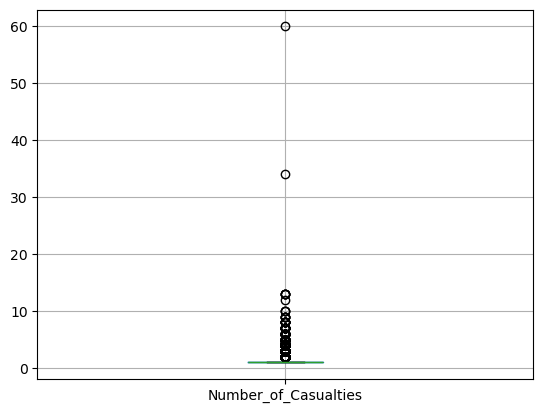

In [19]:
# Boxplot of number of casualties
# Some values can be considered as outliers visually and using the IQR
# They were however not removed because it is possible that accidents tragically may involve such casualties

df_Ac_clean.boxplot(column=['Number_of_Casualties'])
plt.show()

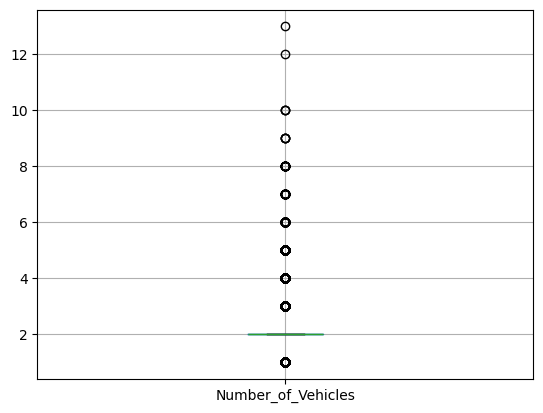

In [20]:
# Boxplot of number of vehicles
# Some values can be considered as outliers visually and using the IQR
# They were however not removed because it is possible that accidents tragically may involve such number of vehicles
df_Ac_clean.boxplot(column=['Number_of_Vehicles'])
plt.show()

#### Get summary of Bikers dataset

In [21]:
# get shape of bikers dataset
df_Bk.shape

(827871, 4)

In [22]:
# get summary of accidents dataset
df_Bk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827871 entries, 0 to 827870
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Accident_Index  827871 non-null  object
 1   Gender          827871 non-null  object
 2   Severity        827871 non-null  object
 3   Age_Grp         827871 non-null  object
dtypes: object(4)
memory usage: 25.3+ MB


In [23]:
# get summary of accidents dataset
df_Bk.describe()

,Accident_Index,Gender,Severity,Age_Grp
count,827871,827871,827871,827871
unique,827871,3,3,9
top,2018983133818,Male,Slight,11 to 15
freq,1,660031,681578,169945


#### Data cleaning for Bikers dataset

In [24]:
# check the number of duplicates
df_Bk.duplicated().sum()

np.int64(0)

In [25]:
# check the number of null values
df_Bk.isnull().sum()

Accident_Index    0
Gender            0
Severity          0
Age_Grp           0
dtype: int64

In [26]:
# Find inconsistent values in the gender column
df_Bk['Gender'].value_counts()

Gender
Male      660031
Female    167721
Other        119
Name: count, dtype: int64

In [27]:
# Find inconsistent values in the severity column
df_Bk['Severity'].value_counts()

Severity
Slight     681578
Serious    139563
Fatal        6730
Name: count, dtype: int64

In [28]:
# Find inconsistent values in the age group column
df_Bk['Age_Grp'].value_counts()

Age_Grp
11 to 15    169945
26 to 35    145081
16 to 20    122604
36 to 45    103774
21 to 25     87292
46 to 55     73578
6 to 10      68021
56 to 65     41913
66 to 75     15663
Name: count, dtype: int64

In [29]:
# backup original dataset before cleaning
df_Bk_clean = df_Bk
df_Bk_clean.head()

,Accident_Index,Gender,Severity,Age_Grp
0,197901A1SEE71,Male,Serious,36 to 45
1,197901A2JDW40,Male,Slight,46 to 55
2,197901A4IJV90,Male,Slight,46 to 55
3,197901A4NIE33,Male,Slight,36 to 45
4,197901A4SKO47,Male,Slight,46 to 55


In [90]:
# set index of dataframe
df_Bk_clean = df_Bk_clean.set_index('Accident_Index')
df_Bk_clean.head()

,Gender,Severity,Age_Grp
Accident_Index,,,
197901A1SEE71,Male,Serious,36 to 45
197901A2JDW40,Male,Slight,46 to 55
197901A4IJV90,Male,Slight,46 to 55
197901A4NIE33,Male,Slight,36 to 45
197901A4SKO47,Male,Slight,46 to 55


#### Univariate Analysis of Bikers Dataset

In [31]:
# Distribution of injury severity
df_Bk_severity_dist = pd.DataFrame({
    'Count (n)': df_Bk_clean['Severity'].value_counts(),
    'Percentage (%)': (df_Bk_clean['Severity'].value_counts(normalize=True).round(2) * 100)
})
df_Bk_severity_dist

,Count (n),Percentage (%)
Severity,,
Slight,681578,82.0
Serious,139563,17.0
Fatal,6730,1.0


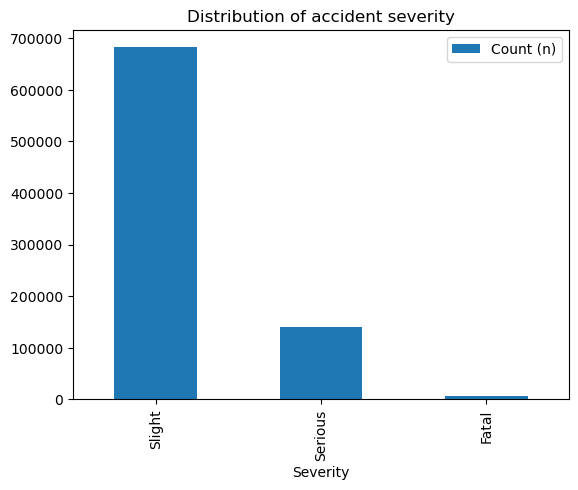

In [32]:
# Bar chart of severity distribution
df_Bk_severity_dist.plot(kind='bar', y='Count (n)', legend='False')
plt.title('Distribution of accident severity')
plt.show()

In [33]:
# Distribution of casualties by gender
df_Bk_gender_dist = pd.DataFrame({
    'Count (n)': df_Bk_clean['Gender'].value_counts(),
    'Percentage (%)': df_Bk_clean['Gender'].value_counts(normalize=True) * 100
})
df_Bk_gender_dist

,Count (n),Percentage (%)
Gender,,
Male,660031,79.726310
Female,167721,20.259316
Other,119,0.014374


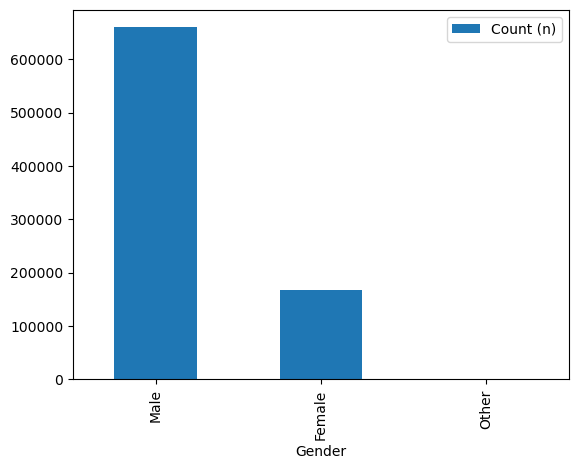

In [34]:
# Bar chart of gender distribution
df_Bk_gender_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Gender distribution of bikers'
plt.show()

In [35]:
# Distribution of casualties by age group
df_Bk_age_grp_dist = pd.DataFrame({
    'Count (n)': df_Bk_clean['Age_Grp'].value_counts(),
    'Percentage (%)': df_Bk_clean['Age_Grp'].value_counts(normalize=True).round(2) * 100
})
df_Bk_age_grp_dist

,Count (n),Percentage (%)
Age_Grp,,
11 to 15,169945,21.0
26 to 35,145081,18.0
16 to 20,122604,15.0
36 to 45,103774,13.0
21 to 25,87292,11.0
46 to 55,73578,9.0
6 to 10,68021,8.0
56 to 65,41913,5.0
66 to 75,15663,2.0


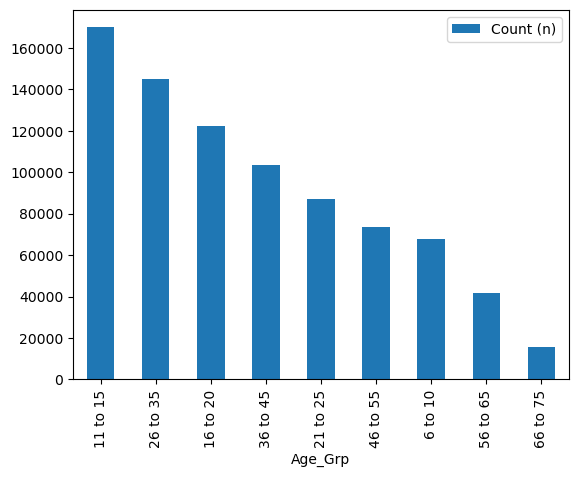

In [36]:
df_Bk_age_grp_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Distribution of casualties by age group'
plt.show()

#### Univariate Analysis of Accident Dataset

In [37]:
# Distribution of road conditions during accidents
df_Ac_road_cond_dist = pd.DataFrame({
    'Count (n)': df_Ac_clean['Road_conditions'].value_counts(),
    'Percentage (%)': df_Ac_clean['Road_conditions'].value_counts(normalize=True).round(4) * 100
})
df_Ac_road_cond_dist

,Count (n),Percentage (%)
Road_conditions,,
Dry,633936,76.58
Wet,184279,22.26
Frost,6020,0.73
Snow,1710,0.21
Missing Data,1648,0.20
Flood,268,0.03


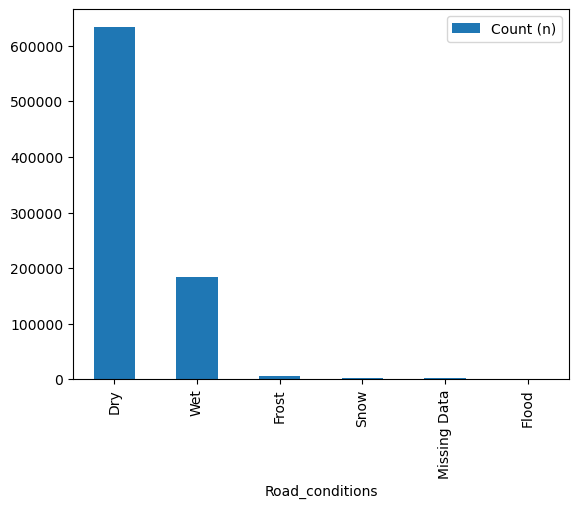

In [38]:
# Bar chart for distribution of road conditions
df_Ac_road_cond_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Distribution of road conditions'
plt.show()

In [39]:
# Distribution of weather conditions during accidents
df_Ac_weather_cond_dist = pd.DataFrame({
    'Count (n)': df_Ac_clean['Weather_conditions'].value_counts(),
    'Percentage (%)': df_Ac_clean['Weather_conditions'].value_counts(normalize=True).round(3) * 100
})
df_Ac_weather_cond_dist

,Count (n),Percentage (%)
Weather_conditions,,
Clear,683162,82.5
Rain,82007,9.9
Unknown,24235,2.9
Clear and windy,11891,1.4
Other,11820,1.4
Rain and windy,8808,1.1
Fog,3369,0.4
Snow,2086,0.3
Snow and windy,483,0.1


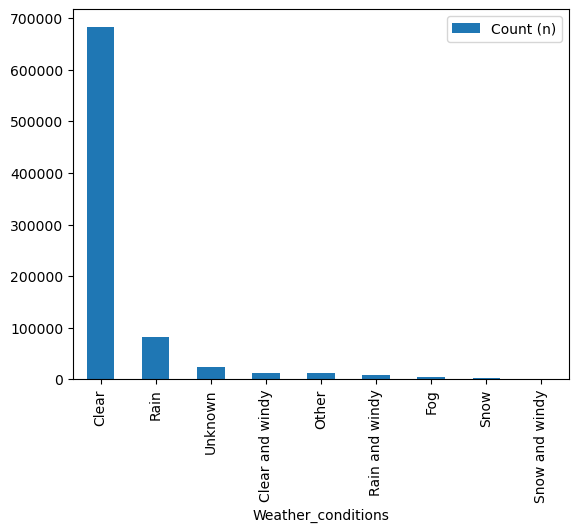

In [40]:
# Bar chart of the distribution of weather conditions
df_Ac_weather_cond_dist.plot(kind='bar', y='Count (n)')
plt.title ='Distribution for weather conditions'
plt.show()

In [41]:
# Distribution of days of the week accidents happened
df_Ac_days_dist = pd.DataFrame({
    'Count (n)': df_Ac_clean['Day'].value_counts(),
    'Percentage (%)': df_Ac_clean['Day'].value_counts(normalize=True).round(4) * 100
})
df_Ac_days_dist

,Count (n),Percentage (%)
Day,,
Wednesday,136756,16.52
Tuesday,136534,16.49
Thursday,136263,16.46
Friday,132066,15.95
Monday,125749,15.19
Saturday,87652,10.59
Sunday,72841,8.80


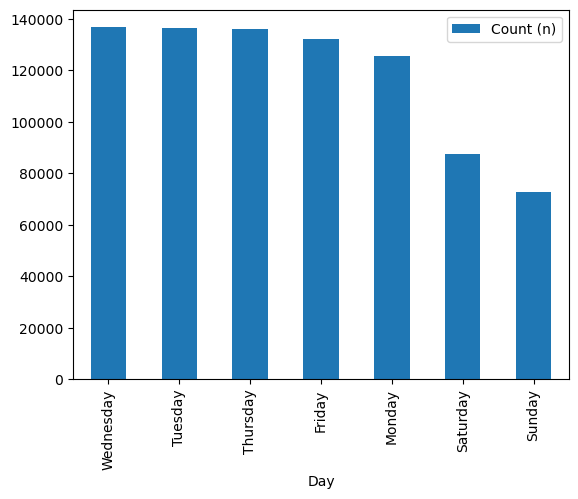

In [42]:
# Bar chart for distribution by day
df_Ac_days_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Distribution of accidents by day of the week'
plt.show()

In [43]:
# Distribution of the roads on which happened
df_Ac_road_type_dist = pd.DataFrame({
    'Count (n)': df_Ac_clean['Road_type'].value_counts(),
    'Percentage (%)': df_Ac_clean['Road_type'].value_counts(normalize=True).round(4) * 100
})
df_Ac_road_type_dist

,Count (n),Percentage (%)
Road_type,,
Single carriageway,656703,79.33
Roundabout,75066,9.07
Dual carriageway,59037,7.13
Unknown,30647,3.70
One way sreet,5562,0.67
Slip road,846,0.10


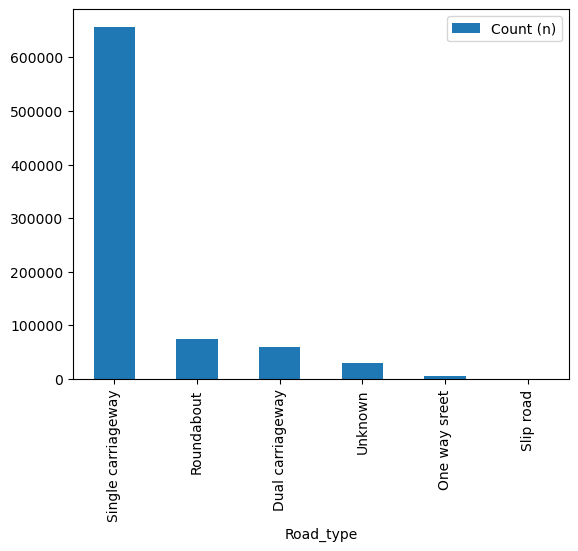

In [44]:
# Bar chart for distribution by road type
df_Ac_road_type_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Distribution of accidents by road type'
plt.show()

In [45]:
# Distribution of the light conditions during accidents
df_Ac_light_condition_dist = pd.DataFrame({
    'Count (n)': df_Ac_clean['Light_conditions'].value_counts(),
    'Percentage (%)': df_Ac_clean['Light_conditions'].value_counts(normalize=True).round(4) * 100
})
df_Ac_light_condition_dist

,Count (n),Percentage (%)
Light_conditions,,
Daylight,660657,79.80
Darkness lights lit,142039,17.16
Darkness no lights,25165,3.04


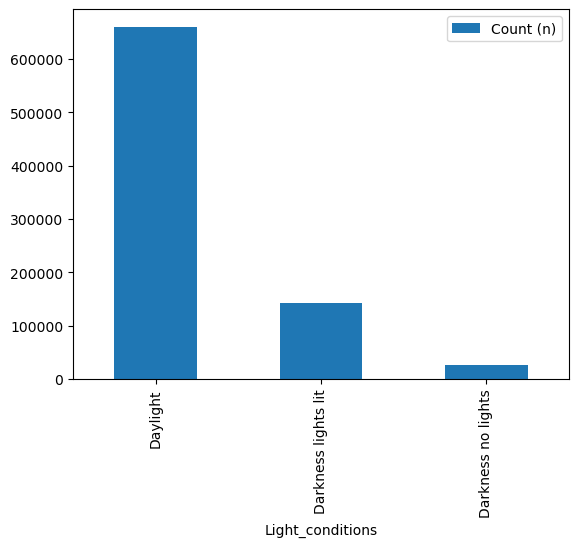

In [46]:
# Bar chart of accident distribution by light condtions
df_Ac_light_condition_dist.plot(kind='bar', y='Count (n)')
plt.title = 'Bar chart of distribution by light conditions'
plt.show()

In [47]:
df_Ac_clean.describe()

,Number_of_Vehicles,Number_of_Casualties,Speed_limit
count,827861.000000,827861.000000,827861.000000
mean,1.986178,1.047212,33.340217
std,0.311600,0.253509,9.252600
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,30.000000
50%,2.000000,1.000000,30.000000
75%,2.000000,1.000000,30.000000
max,13.000000,60.000000,70.000000


##### Normality Tests

In [70]:
def check_normality(data, column_name):
    """Comprehensive normality check"""
    
    print(f"\n{'='*50}")
    print(f"Normality Tests for: {column_name}")
    print(f"{'='*50}")
    
    # 1. Shapiro-Wilk (best for n < 5000)
    stat, p = stats.shapiro(data)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Statistic: {stat:.4f}")
    print(f"  P-value: {p:.4f}")
    print(f"  Normal? {'Yes' if p > 0.05 else 'No'}")
    
    # 2. Kolmogorov-Smirnov
    stat, p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {stat:.4f}")
    print(f"  P-value: {p:.4f}")
    print(f"  Normal? {'Yes' if p > 0.05 else 'No'}")
    
    # 5. Skewness and Kurtosis
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    print(f"\nDescriptive Statistics:")
    print(f"  Skewness: {skew:.4f} (normal ≈ 0. -1 to +1)")
    print(f"  Kurtosis: {kurt:.4f} (normal ≈ 0. -1 to +1)")

# Usage
# check_normality(df['column'], 'column')

In [71]:
# Statistical test for normality of Number of vehicles
check_normality(df_Ac_clean['Number_of_Vehicles'], 'Number_of_Vehicles')


Normality Tests for: Number_of_Vehicles

Shapiro-Wilk Test:
  Statistic: 0.3691
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.4672
  P-value: 0.0000
  Normal? No

Descriptive Statistics:
  Skewness: 1.1493 (normal ≈ 0)
  Kurtosis: 27.3324 (normal ≈ 0)


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)


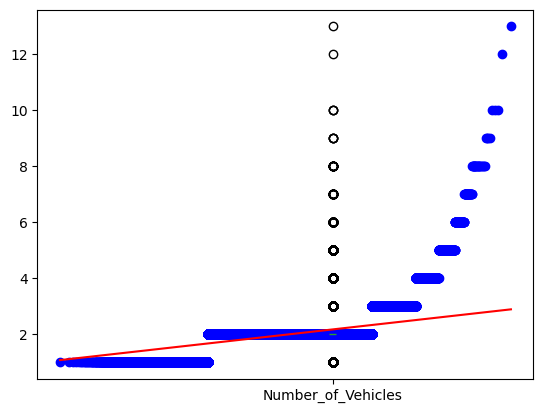

In [87]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot of number of vehicles

# The data can be considered to have a non-uniform distribution from visual methods

df_Ac_clean['Number_of_Vehicles'].hist(bins=40)
df_Ac_clean['Number_of_Vehicles'].plot(kind='box')
stats.probplot(df_Ac_clean['Number_of_Vehicles'], dist="norm", plot=plt)
plt.show()

In [75]:
# Statistical test for normality of Number of casualties
check_normality(df_Ac_clean['Number_of_Casualties'], 'Number_of_Casualties')


Normality Tests for: Number_of_Casualties

Shapiro-Wilk Test:
  Statistic: 0.1738
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.5314
  P-value: 0.0000
  Normal? No


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)



Descriptive Statistics:
  Skewness: 24.5344 (normal ≈ 0)
  Kurtosis: 3978.0675 (normal ≈ 0)


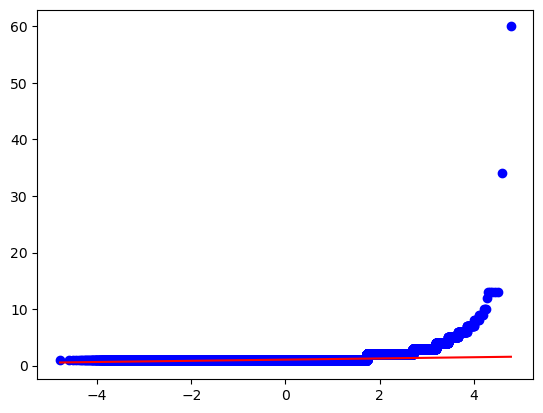

In [81]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot of number of casualties

# The data can be considered to have a non-uniform distribution from visual methods

df_Ac_clean['Number_of_Casualties'].hist(bins=80)
df_Ac_clean['Number_of_Casualties'].plot(kind='box')
stats.probplot(df_Ac_clean['Number_of_Casualties'], dist="norm", plot=plt)
plt.show()

In [82]:
# Statistical test for normality for speed limit
check_normality(df_Ac_clean['Speed_limit'], 'Speed_limit')


Normality Tests for: Speed_limit

Shapiro-Wilk Test:
  Statistic: 0.4661
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.4839
  P-value: 0.0000
  Normal? No

Descriptive Statistics:
  Skewness: 2.5323 (normal ≈ 0)
  Kurtosis: 5.4532 (normal ≈ 0)


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)


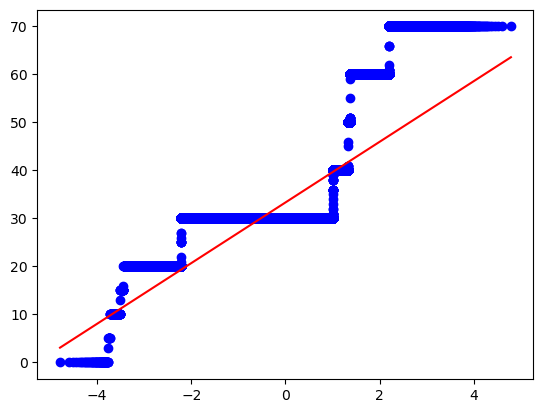

In [85]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot for speed limit

# The data can be considered to have a non-uniform distribution from visual methods

# df_Ac_clean['Speed_limit'].hist(bins=30)
# df_Ac_clean['Speed_limit'].plot(kind='box')
stats.probplot(df_Ac_clean['Speed_limit'], dist="norm", plot=plt)
plt.show()

#### Bivariate analysis of Bikers dataset

In [111]:
# Contigency table for gender and accident severity
gender_severity_count_cross_table = pd.crosstab(df_Bk_clean['Gender'],df_Bk_clean['Severity'])
gender_severity_percent_cross_table = pd.crosstab(df_Bk_clean['Gender'],df_Bk_clean['Severity'], normalize='index') * 100
gender_severity_percent_cross_table.round(2)

Severity,Fatal,Serious,Slight
Gender,,,
Female,0.71,16.01,83.28
Male,0.84,17.08,82.08
Other,0.00,2.52,97.48


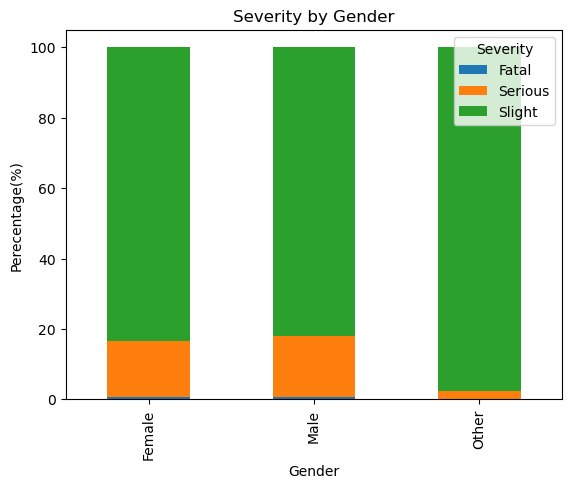

In [119]:
# Barchart for severity by gender
gender_severity_percent_cross_table.plot(kind='bar', stacked=True,xlabel='Gender', 
                                         ylabel='Perecentage(%)', title='Severity by Gender', layout='tight')
plt.show()

In [120]:
# Contigency table for age group and accident severity
age_grp_severity_count_cross_table = pd.crosstab(df_Bk_clean['Age_Grp'],df_Bk_clean['Severity'])
age_grp_severity_percent_cross_table = pd.crosstab(df_Bk_clean['Age_Grp'],df_Bk_clean['Severity'], normalize='index') * 100
age_grp_severity_percent_cross_table.round(2)

Severity,Fatal,Serious,Slight
Age_Grp,,,
11 to 15,0.68,16.62,82.70
16 to 20,0.58,15.26,84.16
21 to 25,0.53,14.57,84.90
26 to 35,0.57,14.79,84.64
36 to 45,0.78,17.26,81.97
46 to 55,1.24,20.48,78.28
56 to 65,2.06,23.46,74.48
6 to 10,0.57,16.94,82.49
66 to 75,3.84,26.18,69.98


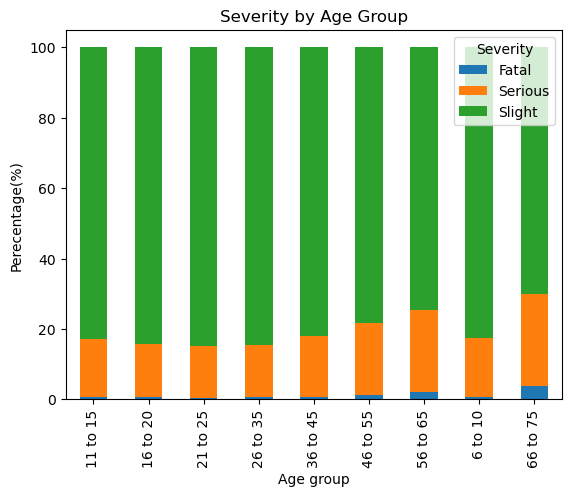

In [121]:
# Barchart for severity by age group
age_grp_severity_percent_cross_table.plot(kind='bar', stacked=True,xlabel='Age group', 
                                         ylabel='Perecentage(%)', title='Severity by Age Group', layout='tight')
plt.show()

In [151]:
# Contigency table for age group and gender 
gender_age_group_count_cross_table = pd.crosstab(df_Bk_clean['Age_Grp'],df_Bk_clean['Gender'])
gender_age_group_percent_cross_table = pd.crosstab(df_Bk_clean['Age_Grp'],df_Bk_clean['Gender'], normalize='index') * 100
gender_age_group_percent_cross_table.round(2)

Gender,Female,Male,Other
Age_Grp,,,
11 to 15,15.19,84.79,0.02
16 to 20,18.48,81.50,0.02
21 to 25,25.67,74.32,0.01
26 to 35,22.54,77.45,0.01
36 to 45,20.78,79.21,0.01
46 to 55,23.54,76.45,0.01
56 to 65,24.16,75.82,0.01
6 to 10,17.27,82.68,0.04
66 to 75,21.50,78.48,0.02


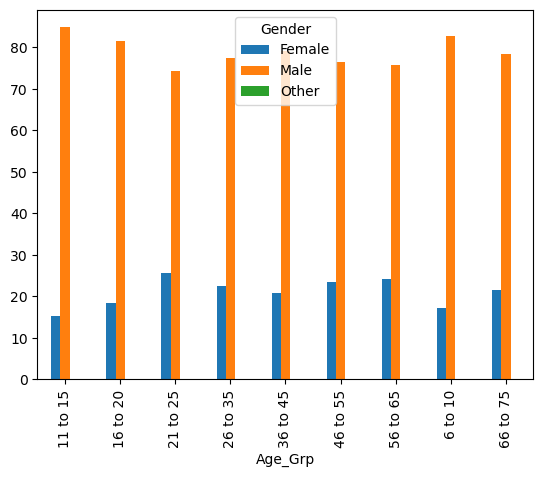

In [152]:
# Barchart for age group and gender
gender_age_group_percent_cross_table.plot(kind='bar')
plt.show()

#### Bivariate analysis for Accidents dataset

In [182]:
df_Ac_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827861 entries, 197901A1SEE71 to 2018983133818
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Number_of_Vehicles    827861 non-null  int64         
 1   Number_of_Casualties  827861 non-null  int64         
 2   Date                  827861 non-null  datetime64[ns]
 3   Time                  827861 non-null  object        
 4   Speed_limit           827861 non-null  float64       
 5   Road_conditions       827861 non-null  object        
 6   Weather_conditions    827861 non-null  object        
 7   Day                   827861 non-null  object        
 8   Road_type             827861 non-null  object        
 9   Light_conditions      827861 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 101.7+ MB


In [219]:
# Casualty statistics by day of the week
casualties_by_day = pd.DataFrame(df_Ac_clean.groupby('Day')['Number_of_Casualties'].sum().sort_values())
casualties_by_day

,Number_of_Casualties
Day,
Sunday,77858
Saturday,92544
Monday,131446
Friday,137828
Thursday,142271
Tuesday,142413
Wednesday,142586


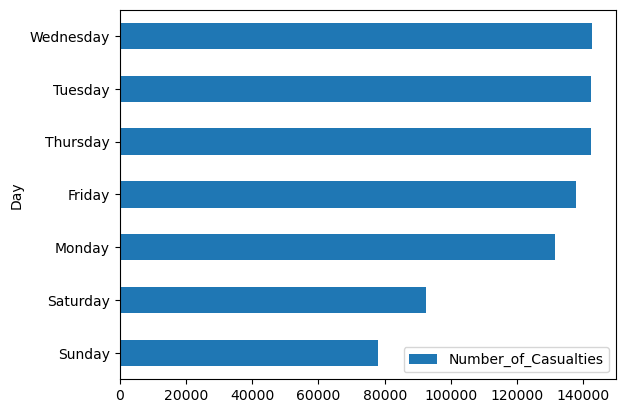

In [221]:
# Barchart of Casualty statistics by day of the week
casualties_by_day.plot(kind='barh')
plt.show()

In [216]:
# Casualty statistics by road conditions
casualties_by_road_conditions = pd.DataFrame(df_Ac_clean.groupby('Road_conditions')['Number_of_Casualties'].sum().sort_values())
casualties_by_road_conditions

,Number_of_Casualties
Road_conditions,
Flood,285
Missing Data,1697
Snow,1761
Frost,6289
Wet,192075
Dry,664839


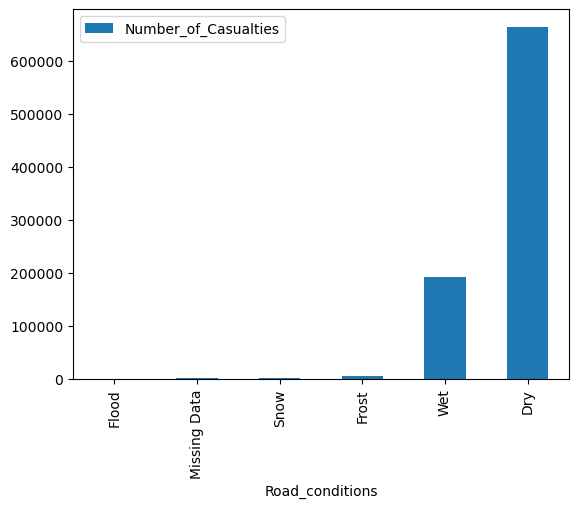

In [218]:
# Barchart of Casualty statistics by road conditions
casualties_by_road_conditions.plot(kind='bar')
plt.show()

In [225]:
# Casualty statistics by weather conditions
casualties_by_weather_conditions = pd.DataFrame(df_Ac_clean.groupby('Weather_conditions')['Number_of_Casualties'].sum().sort_values())
casualties_by_weather_conditions

,Number_of_Casualties
Weather_conditions,
Snow and windy,498
Snow,2159
Fog,3479
Rain and windy,9114
Other,12088
Clear and windy,12427
Unknown,25335
Rain,85189
Clear,716657


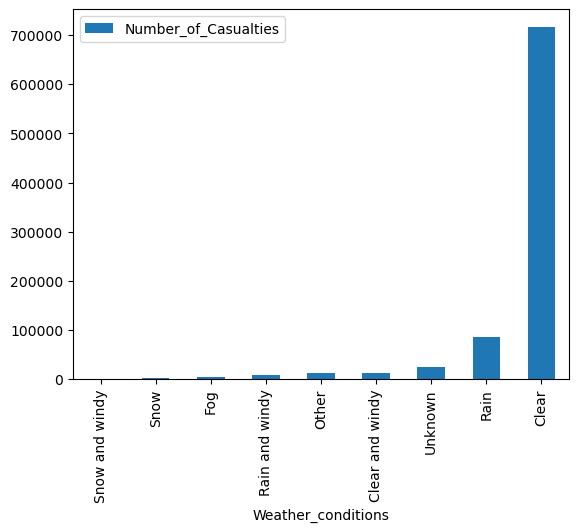

In [228]:
# Barchart of Casualty statistics by weather conditions
casualties_by_weather_conditions.plot(kind='bar')
plt.show()

In [233]:
# Casualty statistics by road type
casualties_by_road_type = pd.DataFrame(df_Ac_clean.groupby('Road_type')['Number_of_Casualties'].sum().sort_values())
casualties_by_road_type

,Number_of_Casualties
Road_type,
Slip road,875
One way sreet,5756
Unknown,31963
Dual carriageway,62286
Roundabout,76441
Single carriageway,689625


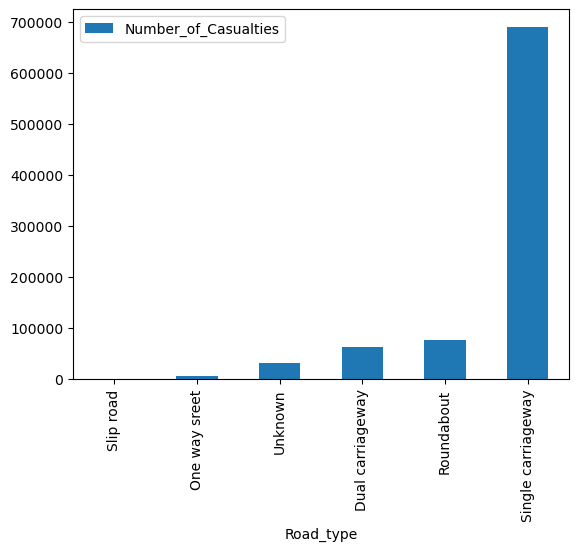

In [232]:
# Barchart of Casualty statistics by road type
casualties_by_road_type.plot(kind='bar')
plt.show()

In [234]:
# Casualty statistics by light conditions
casualties_by_light_conditions = pd.DataFrame(df_Ac_clean.groupby('Light_conditions')['Number_of_Casualties'].sum().sort_values())
casualties_by_light_conditions

,Number_of_Casualties
Light_conditions,
Darkness no lights,26807
Darkness lights lit,147654
Daylight,692485


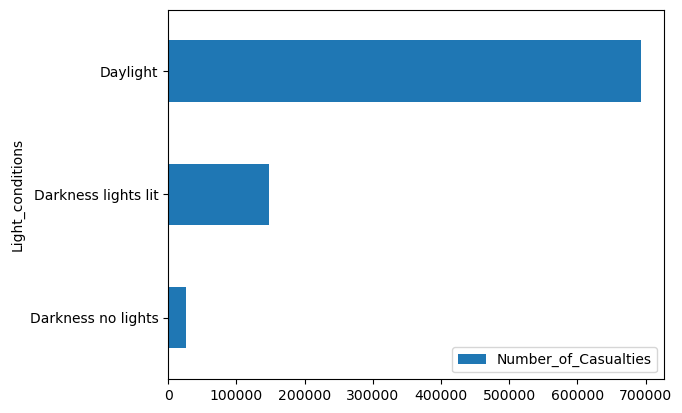

In [236]:
# Barchart of Casualty statistics by light conditions
casualties_by_light_conditions.plot(kind='barh')
plt.show()

In [252]:
# Casualty burdern light condition and road type 
casualties_by_road_type_light_conditions = pd.DataFrame(df_Ac_clean.groupby(['Road_type','Light_conditions'], as_index=False)['Number_of_Casualties'].sum())
casualties_by_road_type_light_conditions

,Road_type,Light_conditions,Number_of_Casualties
0,Dual carriageway,Darkness lights lit,11359
1,Dual carriageway,Darkness no lights,2319
2,Dual carriageway,Daylight,48608
3,One way sreet,Darkness lights lit,1111
4,One way sreet,Darkness no lights,95
5,One way sreet,Daylight,4550
6,Roundabout,Darkness lights lit,19057
7,Roundabout,Darkness no lights,1807
8,Roundabout,Daylight,55577
9,Single carriageway,Darkness lights lit,111214


In [253]:
# Casualty burdern weather condition and road type day
casualties_by_road_type_weather_conditions = pd.DataFrame(df_Ac_clean.groupby(['Road_type','Weather_conditions'], as_index=False)['Number_of_Casualties'].sum())
casualties_by_road_type_weather_conditions

,Road_type,Weather_conditions,Number_of_Casualties
0,Dual carriageway,Clear,51436
1,Dual carriageway,Clear and windy,1138
2,Dual carriageway,Fog,239
3,Dual carriageway,Other,781
4,Dual carriageway,Rain,6121
5,Dual carriageway,Rain and windy,740
6,Dual carriageway,Snow,150
7,Dual carriageway,Snow and windy,37
8,Dual carriageway,Unknown,1644
9,One way sreet,Clear,4976


In [ ]:
# Time - Series
# Morning Rush Hour: 7-9
# Inter Peak: 10-15
# Afternoon School Pickup: 15-16
# Evening Rush Hour: 17-19
# Late Evening: 19+
# Friday Afternoon Rush Hour: 15-19